# BirdFlock
Este ejemplo pretende simular el comportamiento de una bandada de pájaros: cientos, o incluso miles, de pájaros volando juntos, formando formas infinitas como si fueran una sola entidad. Para el desarrollo de este ejemplo, nos basaremos en el trabajo presentado por [Rohola Zandie](https://betterprogramming.pub/boids-simulating-birds-flock-behavior-in-python-9fff99375118).

## ¿Cómo funciona el modelo?
Una propuesta de solución a este problema fue presentado por Craig Reynolds cuando introdujo un sistema conocido como "Boids" que podía simular algo similar al comportamiento de bandadas de aves. Su modelo estable tres reglas simples:
* **Separación**: La separación es necesaria para que nuestros individuos choquen entre sí y se estrellen. Cada individuos debe ver a sus propios compañeros de bandada locales y alejarse si están demasiado cerca.
<center>
<img src="https://miro.medium.com/max/217/1*vcc16ijg_e8lMOTRIhhm9w.gif" />
</center>
* **Alineación**: Cada invidividuo solo ve a los individuos que están a su alrededor. Para la alineación, miramos los vecinos y calculamos su dirección promedio (que es parte del vector de velocidad) y seguimos eso.
<center>
<img src="https://miro.medium.com/max/217/1*e8AAGeLm9x0i6kkO4_Yenw.gif" />
</center>
* **Cohesión**: Significa dirigirse hacia el centro de masa de los compañeros de bandada locales. Hacemos esto para forzar a que los individuos se peguen entre sí y no se dividan.
<center>
<img src="https://miro.medium.com/max/217/1*Au6eWj6jETcbVAbQWJR1-g.gif" />
</center>

A diferencia de otros ejemplos, no queremos realizar una animación basada en una matriz sino en objetos que se mueven libremente en un espacio bidimencional. Para ello, tendremos que usar una biblioteca que pueda encargarse del manejo de vectores. La biblioteca que usaremos es `p5`. Primero, necesitamos instalarla:

**IMPORTANTE**. Para trabajar con este ejemplo, es necesario instalar [p5](https://p5.readthedocs.io/en/latest/install.html#)

## Imports

In [1]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Con ''SimultaneousActivation, hacemos que todos los agentes se activen ''al azar''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [2]:
class FlockAgent(Agent):
    def __init__(self, unique_id, model, x, y, width, height):
        super().__init__(unique_id, model)
        
        # Representa la posición del agente usando un vector 2D
        self.position = np.array((x, y), dtype=np.float64)
    
        # Generamos aleatoriamente un vector que representa la velocidad del agente.
        vec = (np.random.rand(2) - 0.5)*10
        self.velocity = np.array(vec, dtype=np.float64)
        
        # Generamos aleatoriamente un vector que representa la aceleración del agente.
        vec = (np.random.rand(2) - 0.5)/2
        self.acceleration = np.array(vec, dtype=np.float64)
        
        # Aceleración que deben de tener para poder alinearse.
        self.max_force = 0.3
        
        # Magnitud máxima que puede tener el vector de velocidad.
        self.max_speed = 5
        
        # Distancia percibida como adecuada por el agente.
        self.perception = 100
        
        self.width = width
        self.height = height
        
    def step(self):
        self.check_edges()
        self.check_with_neighbours()
        
        self.position = self.position + self.velocity
        self.velocity = self.velocity + self.acceleration
        
        # Limitaremos la velocidad máxima. Para ello, vamos a normalizar el vector para verificar que su magnitud
        # no exceda de un tope definido.
        if np.linalg.norm(self.velocity) > self.max_speed:
            self.velocity = self.velocity / np.linalg.norm(self.velocity) * self.max_speed
            
        self.acceleration = np.array([0, 0], dtype=np.float64)
        
    def check_edges(self):
        if self.position.flatten()[0] > self.width:
            self.position[0] = 0
        elif self.position.flatten()[0] < 0:
            self.position[0] = self.width
            
        if self.position.flatten()[1] > self.height:
            self.position[1] = 0
        elif self.position.flatten()[1] < 0:
            self.position[1] = self.height
            
    def check_with_neighbours(self):
        alignment = self.align()
        cohesion = self.cohesion()
        separation = self.separation()
        
        self.acceleration = self.acceleration + alignment
        self.acceleration = self.acceleration + cohesion
        self.acceleration = self.acceleration + separation
        
    def align(self):
        steering = np.array([0, 0], dtype=np.float64)
        total = 0
        avg_vector = np.array([0, 0], dtype=np.float64)
        for agent in model.schedule.agents:
            if np.linalg.norm(agent.position - self.position) < self.perception:
                avg_vector = avg_vector + agent.velocity
                total += 1
        if total > 0:
            avg_vector /= total
            avg_vector = (avg_vector / np.linalg.norm(avg_vector)) * self.max_speed
            steering = avg_vector - self.velocity
        return steering

    def cohesion(self):
        steering = np.array([0, 0], dtype=np.float64)
        total = 0
        center_of_mass = np.array([0, 0], dtype=np.float64)
        for agent in model.schedule.agents:
            if np.linalg.norm(agent.position - self.position) < self.perception:
                center_of_mass = center_of_mass + agent.position
                total += 1
        if total > 0:
            center_of_mass /= total
            vec_to_com = center_of_mass - self.position
            if np.linalg.norm(vec_to_com) > 0:
                vec_to_com = (vec_to_com / np.linalg.norm(vec_to_com)) * self.max_speed
            steering = vec_to_com - self.velocity
            if np.linalg.norm(steering) > self.max_force:
                steering = (steering / np.linalg.norm(steering)) * self.max_force   
        return steering
            
    def separation(self):
        steering = np.array([0, 0], dtype=np.float64)
        total = 0
        avg_vector = np.array([0, 0], dtype=np.float64)
        for agent in model.schedule.agents:
            distance = np.linalg.norm(agent.position - self.position)
            if not(np.array_equal(self.position, agent.position)) and distance < self.perception:
                diff = (self.position - agent.position) / distance
                avg_vector = avg_vector + diff
                total += 1
        if total > 0:
            avg_vector /= total
            if np.linalg.norm(avg_vector) > 0:
                avg_vector = (avg_vector / np.linalg.norm(avg_vector)) * self.max_speed
            steering = avg_vector - self.velocity
            if np.linalg.norm(steering) > self.max_force:
                steering = (steering /np.linalg.norm(steering)) * self.max_force
        return steering

In [3]:
def get_particles(model):
    result = []
    for agent in model.schedule.agents:
        result.append(agent.position)
    result = np.asarray(result)
    return result

class FlockModel(Model):
    def __init__(self, N, width, height):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        
        # Creando agentes
        for i in range(self.num_agents):
            # unique_id, model, x, y, width, height):
            a = FlockAgent(i, self, np.random.rand()*1000, np.random.rand()*1000, width, height)
            self.schedule.add(a)
            
        self.datacollector = DataCollector(model_reporters = {"Particles" : get_particles})
            
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [5]:
WIDTH = 1000
HEIGHT = 1000
N = 200
MAX_ITERATIONS = 500

# Registramos el tiempo de inicio y ejecutamos la simulación
start_time = time.time()

model = FlockModel(N, WIDTH, HEIGHT)
for i in range(MAX_ITERATIONS):
    model.step()
    
# Imprimimos el tiempo que le tomó correr al modelo.
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(time.time() - start_time))))

Tiempo de ejecución: 0:04:41.929421


In [6]:
all_positions = model.datacollector.get_model_vars_dataframe()

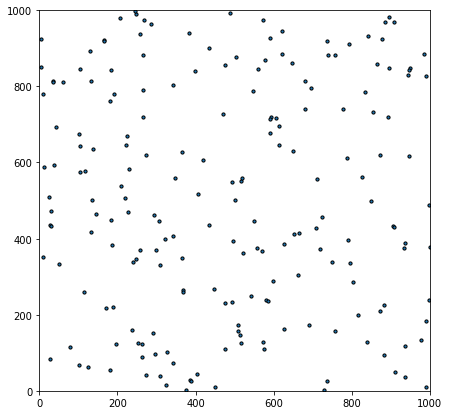

In [8]:
fig, ax = plt.subplots(figsize=(7,7))
scatter = ax.scatter(all_positions.iloc[0][0][:,0], all_positions.iloc[0][0][:,1], 
                  s=10, cmap="jet", edgecolor="k")
ax.axis([0, WIDTH, 0, HEIGHT])
def update(frame_number):
    scatter.set_offsets(all_positions.iloc[frame_number][0])
    return scatter

anim = animation.FuncAnimation(fig, update, frames=MAX_ITERATIONS)

In [9]:
anim